## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Model Definition and Training](#model_training)
* [Model Evaluation](#model_evaluation)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

The aim of this project is to build a time-series model using **Recurrent Neural Networks (RNNs)** in an attempt to forecast the value  for the next 6 hours. 


### Initial Data Exploration and Feature Engineering

We will be using <a href="https://keras.io/">Keras</a> for our purpose. Keras is a user-friendly open-source library used for working with Machine Learning models and runs on top of <a href="https://www.tensorflow.org/about">Tensorflow</a> which is also a free and open-source software library that provides you with a framework for this purpose.

In [ ]:
import tensorflow as tf

# Eager Execution offers an intuitive interface with easier debugging and natural control flow.
tf.compat.v1.enable_eager_execution() 

Let's load and explore the data frame.

In [ ]:
# Import pandas to load the data.
import pandas as pd
df = pd.read_csv("/content/dataset.csv")

# Display the first ten rows of the data frame.
df.head(10)

,date,Value,K1,K2,DayN,K3
0,01/07/2019 00:00,0,0,0,0,0
1,01/07/2019 01:00,0,0,0,0,0
2,01/07/2019 02:00,0,0,0,0,0
3,01/07/2019 03:00,0,0,0,0,0
4,01/07/2019 04:00,0,0,0,0,0
5,01/07/2019 05:00,0,0,0,0,0
6,01/07/2019 06:00,0,0,0,0,0
7,01/07/2019 07:00,0,0,0,0,0
8,01/07/2019 08:00,0,0,0,0,0
9,01/07/2019 09:00,1,1,0,0,0


Before making any major modifications in the data frame, we need to save some of the most basic information concerning the data. We can use this information as a reference later on if something goes wrong while working on it.

In [ ]:
# Format the date_time column and make it the index.
df.date = pd.to_datetime(df['date']).dt.strftime('%m/%d/%Y,  %H:%M')
df.index = df['date']

# Extract the number of rows and columns by using the shape of the data.
numRows,numColumns = df.shape
# Extract the time interval.
last_date, first_date = df.iloc[0].date, df.iloc[-1].date
# Check the availability of the data.
na_cols = df.columns[df.isna().any()].tolist()

# Print the information.
print(f"There are {numRows} rows and {numColumns} columns in the initial dataset.")
print(f"The data represents the time frame between the dates '{last_date}' and '{first_date}'.")
if not na_cols:
  print("There are no NA rows.")
else:
  print(f"Columns in the dataset which include NA rows: {na_cols}.") 

There are 4416 rows and 6 columns in the initial dataset.
The data represents the time frame between the dates '01/07/2019,  00:00' and '12/31/2019,  23:00'.
There are no NA rows.


As you can see, the output of the cell above includes significant information about the time frame and the shape of our data. In the next cell, we remove all the columns which may not be converted to type "float64". Any other data type than this (including strings) is not related to the training process of our model and therefore shall be omitted.

In [ ]:
# Iterate over each column in df and try to convert its type to float if it's convertible. 
# Otherwise remove the column from the data frame.

for column in df:
  try:
    df[column] = df[column].astype('float')
  except:
    df.drop(column, axis=1, inplace=True)

# Display that all the remaining columns are of type 'float64'.
df.dtypes

Value    float64
K1       float64
K2       float64
DayN     float64
K3       float64
dtype: object

Before moving on to feature selection, it is good practice to check some statistical facts for our data set. Let's take our time to look for anything that seems suspicious and abnormal in the stats. 

In [ ]:
# Basic statistics about our data.
df.describe()

,Value,K1,K2,DayN,K3
count,4416.000000,4416.000000,4416.000000,4416.000000,4416.000000
mean,8.314085,0.617527,0.615942,2.972826,1.817029
std,2.330135,1.182450,1.341779,2.006825,0.751014
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,1.000000,1.000000
50%,9.000000,0.000000,0.000000,3.000000,2.000000
75%,10.000000,1.000000,1.000000,5.000000,2.000000
max,14.000000,9.000000,11.000000,6.000000,3.000000


We have to know how different columns relate to each other. We will use the *Pearson Correlation Coefficient* for this step. We don't want to include all the columns because it is important to use as few variables as possible during training. This will improve the accuracy of our model as well as reduce training time and the amount of information loss.

In [ ]:
# Correlation between each feature and the Value.
df.corr('pearson').Value

Value    1.000000
K1       0.115705
K2      -0.176281
DayN    -0.074560
K3       0.925536
Name: Value, dtype: float64

In [ ]:
# The following libraries are used for data manipulation and visualization.
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline
import numpy as np

# Change the style of the graphs. This is optional.
plt.style.use('dark_background')

After importing the necessary libraries, we will now plot a graph showing us once more, but this time more clearly, how the features correlate. 

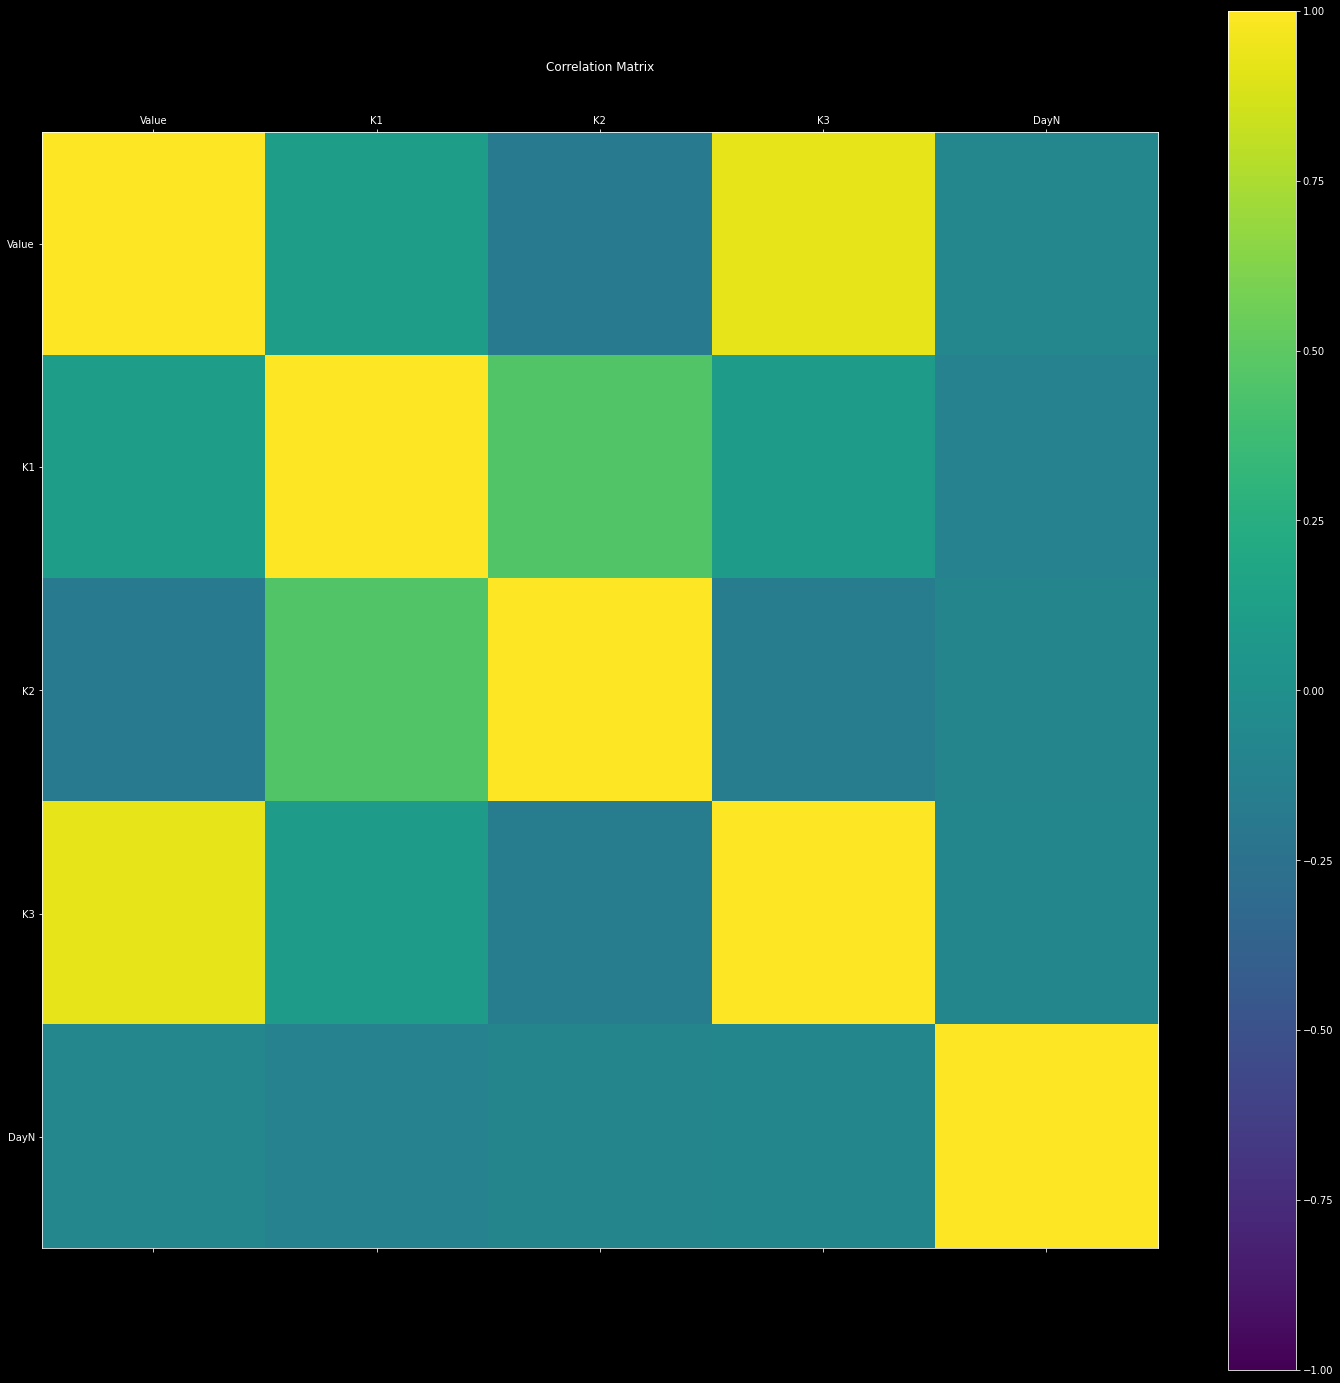

In [ ]:
# Create a new variable containing the selected features to continue with.
features = df[['Value','K1','K2','K3','DayN',
               ]]

# Visualize the correlation matrix.
fig = plt.figure(figsize=(25,25)) 
ax = fig.add_subplot(111) # 1x1 grid, first subplot.
fig.colorbar(ax.matshow(features.corr(), vmin=-1, vmax=1)) 
ticks = np.arange(len(features.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(features.columns)
ax.set_yticklabels(features.columns)
plt.title("Correlation Matrix")

plt.show()

To verify that the features are in the correct format, let's plot graphs for each seperate feature and observe how they evolve over time. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efedb71e2b0>,
      dtype=object)

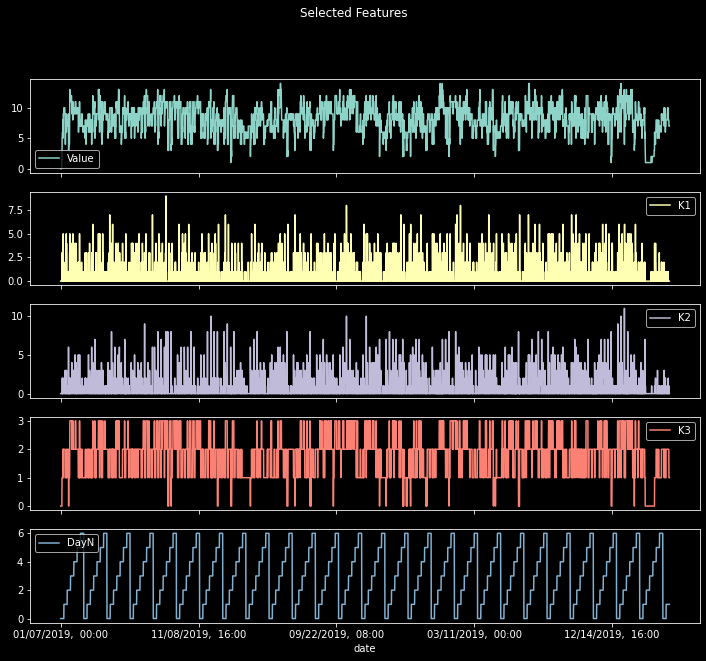

In [ ]:
# Create a plot which shows how the selected features change over time.
features.plot(subplots=True,figsize=(12,10),title='Selected Features')

It is incredibly important to normalize the data set within the specified range. This may help the learning algorithm to work faster and more efficiently. MinMaxScaler is an algorithm which does exactly this. It transforms all the values and fits them in a range between 0 and 1.

In [ ]:
# scikit-learn is a free software machine learning library. 
import sklearn
from sklearn.preprocessing import MinMaxScaler

# Scale the data using MinMaxScaler within the range 0 to 1 and assign the scaled data to a new variable.
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(features.values)


## Methodology <a name="methodology"></a>

In this project, we will try to build a model which learns from data in the form of time-series and then predicts the new timesteps. To achieve this, we will use RNNs because they are arguably the best type of machine learning algorithm for our case. Until this step, we have obtained the required data, cleaned and explored it and selected the appropriate features for training the model. Then we have eliminated some of the features after examining the Pearson correlation matrix. The reason we are not using all the features is that it would not increase model performance, on the contrary, it would decrease it because when we train an ML model which takes multivariate data as input, the learning algorithm applies feature reduction to the data and some information is lost in the course of this task. This situation is called the Curse of Dimensionality. We don't want too much data being lost, so we only choose the features that are essential for the objective. The following step of our project is the actual building/training process. Then we will evaluate the model using the appropriate methods.


## Model Definition and Training <a name="model_training"></a>

### Compiling the Model

It is recommended that you study the code for this step in true detail and understand how it works. 

First, we define two variables; "past" represents the number of hours our model will be able to look into the past and "future" represents the number of hours our model will predict into the future.  

We then define the **batch size** and the **train/test splitting point**. The *batch size* is a hyperparameter which represents the number of samples used before updating the model weights. After working with different batch sizes, we've decided to use 256 separate batches to train our model. We will use the SPLIT variable for splitting the data into train data and test data. In order to calculate the splitting point, we used; the batch size, the shape of our data and a test percentage of ~0.33.  

After we specify this information, we split the data into two separate parts using the splitting point. The first one is used for training the model and the rest is used as validation data. We also create a variable called "indices" which holds the index values of the test set for visualization.

In [ ]:
# The model will be able to "see" the weather belonging to past 5 days (120 hours). 
past = 120
# The model should be able to forecast the Value for the next 24 hours.
future = 6

BATCH_SIZE = 256
SPLIT = 400

# Use list comprehensions for splitting the data into train and test sets.
x_train, y_train = map(np.array, zip(*[(dataset[range(k-past, k)], dataset[:,1][k:k+future]) for k in range(past, SPLIT)]))
x_test, y_test = map(np.array, zip(*[(dataset[range(k-past, k)], dataset[:,1][k:k+future]) for k in range(SPLIT+past, len(dataset)-future)]))

indices = [range(k-past, k+future, future) for k in range(SPLIT+past, len(dataset)-future)]

One of the most important things to pay attention to while forming the train and test sets is the fact that we are shuffling the training data before we feed it to the model. The reason for this is that the original data is nonstationary, meaning that it involves seasonality. Removing seasonality in a dataset to make it stationary, more often than not improves the model performance. If we wanted to, we could check whether our data was stationary or not by computing some statistical tests, such as KPSS and ADF. However, it would be beyond the scope of this project since this is an introductory notebook.

In [ ]:
# Shuffle training data to remove seasonality.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(10000).batch(BATCH_SIZE).repeat()

# Do NOT shuffle test data.
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(BATCH_SIZE).repeat()

Let's define and then compile the model. We start by adding two LSTM (a specialized RNN) layers to our model and a final Dense layer which is used to connect each input neuron to an output neuron and has the shape equal to the output dimension, i.e. the number of hours we want to predict. We decided to use <a href="https://www.researchgate.net/publication/323956667_Deep_Learning_using_Rectified_Linear_Units_ReLU">ReLU (Rectified Linear Units)</a> as our activation function, since it is particularly famous as it overcomes the Vanishing Gradient problem. It is also useful if you are a beginner as it's generally adaptable to many different cases.

In order to compile the model, we need to pass an optimizer as an argument to the *compile()* method. While there is no standard recipe for choosing a learning method for a model, RMSprop is an optimizer which uses an adaptive learning rate and it works generally well with big datasets. So we will go with that one. 

It is recommended that you don't modify the following cell a lot, unless you possess advanced knowledge of the domain.

In [ ]:
# Define a Sequential Model.
model = tf.keras.models.Sequential()

# Add layers to the model. 
model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(tf.keras.layers.LSTM(16, activation='relu'))
model.add(tf.keras.layers.Dense(future))

# Compile the model.
model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
# Display a summary representation of our model.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 32)           4864      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
Total params: 8,102
Trainable params: 8,102
Non-trainable params: 0
_________________________________________________________________


### Training the Model

So, how do we fit the data into the model? While this step is pretty straightforward, there are some things you should pay attention to. First of all, you should specify the number of epochs, steps per epoch, validation data and validation steps arguments. You can increase the number of steps for better results. Another thing to keep in mind is that the fit() method also returns a complete history of the training process apart from doing the actual training task. We will assign a variable to this method for keeping a record of the training loss and the validation loss. 

When you execute the following cell, the training will begin and it is likely to take some time. If you don't want to wait, you can skip this step by adjusting the number of epochs and the number of steps per epoch or you can download the pre-trained model from GitHub and upload it to the notebook. 


In [ ]:
# An epoch refers to a cycle through the training set.
EPOCHS = 2
# Since one entire cycle is too big in our case, use steps.
STEPS_PER_EPOCH = 1000

# Fit the data into the model.
hist = model.fit(train_data, epochs=EPOCHS,
                 steps_per_epoch=STEPS_PER_EPOCH,
                 validation_data=test_data,
                 validation_steps=500)

Epoch 1/2
1000/1000 [==============================] - 162s 159ms/step - loss: 0.0644 - val_loss: 0.0688
Epoch 2/2
1000/1000 [==============================] - 156s 156ms/step - loss: 0.0643 - val_loss: 0.0688


In [ ]:
# PATH = '.../istanbul_weather_model.h5'
# model = tf.keras.models.load_model(PATH)

## Model Evaluation <a name="model_evaluation"></a>

If we train the model more than we should, the model starts hallucinating non-existent patterns and the accuracy starts to decrease instead of increasing, then we call this situation "**overfitting**". To detect this and prevent it from happening, we keep record of the loss functions during the training step. Since the size of our training set is pretty large, it is unlikely that we are overfitting but there is no harm in checking.



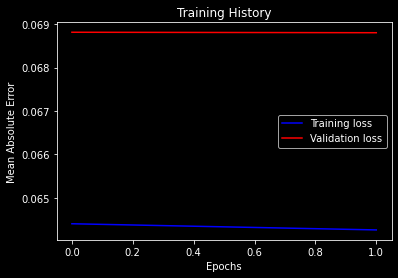

In [ ]:
# Visualize a plot of loss on the training and validations sets over training epochs.

plt.figure()

plt.plot(range(len(hist.history['loss'])), hist.history['loss'], 'b', label='Training loss')
plt.plot(range(len(hist.history['val_loss'])), hist.history['val_loss'], 'r', label='Validation loss')
plt.title('Training History')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()

plt.show()

We have chosen the *Root Mean Squared Error (RMSE)* as our evaluation metric. It is calculated by taking the square root of square of the difference between the test data and the predictions made by the model. What we are going to do is to take samples from the validation data and make predictions for each of them. We will plot our forecast and the real values on a graph. Finally, we will calculate the error and add that to the graph too. What's good about this metric is that it prevents large errors and in our case large errors are undesirable. Additionally, thanks to the existance of the square root in RMSE formula, the scale of errors is the same as the scale of target values. 

![RMSE Formula](https://community.qlik.com/legacyfs/online/128958_2016-06-23%2013_45_36-Root%20Mean%20Squared%20Error%20_%20Kaggle.png)


##Forecasting 

Finally, let's plot the predictions created by using the test data. We will look at these examples for evaluating the performance of our model. 

8/8 [==============================] - 0s 21ms/step


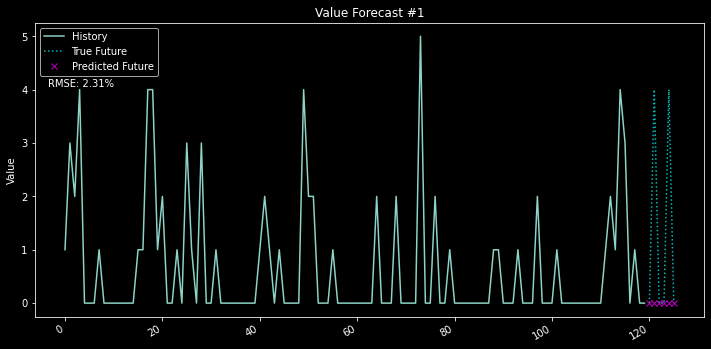

8/8 [==============================] - 0s 20ms/step


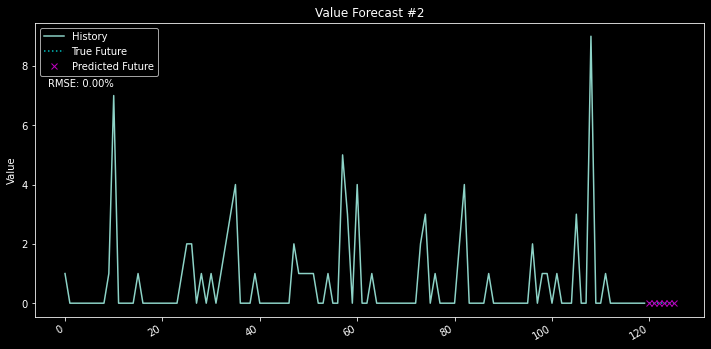

8/8 [==============================] - 0s 21ms/step


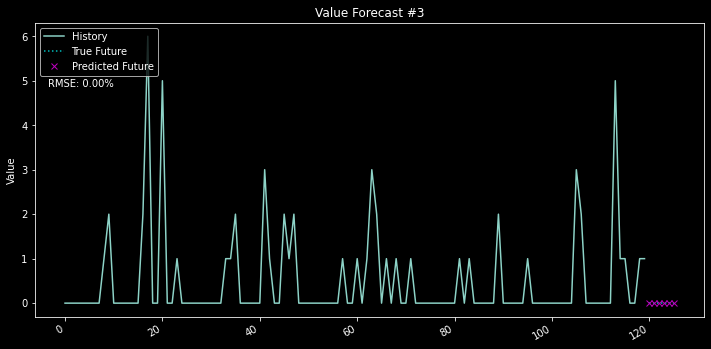

8/8 [==============================] - 0s 20ms/step


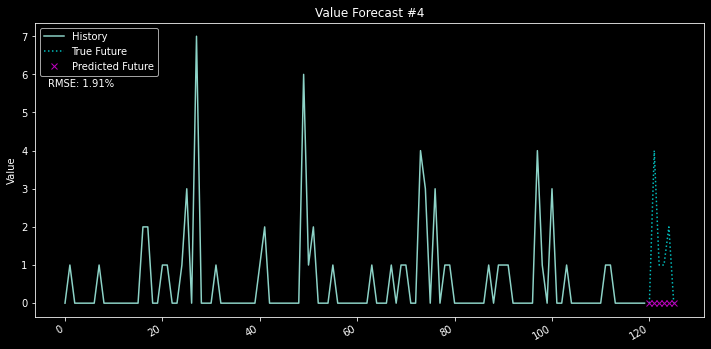

8/8 [==============================] - 0s 21ms/step


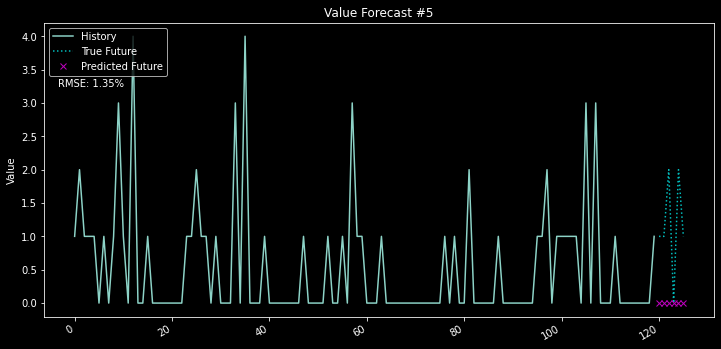

8/8 [==============================] - 0s 21ms/step


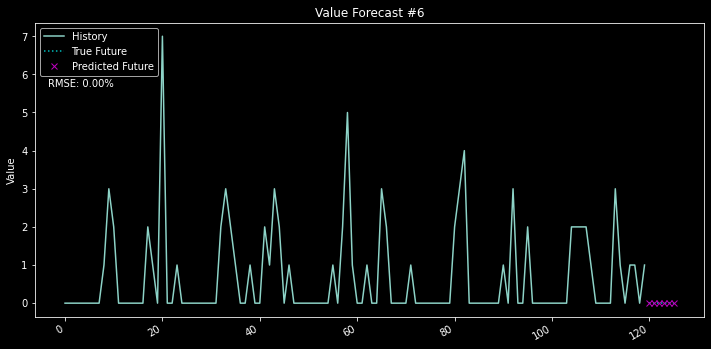

8/8 [==============================] - 0s 23ms/step


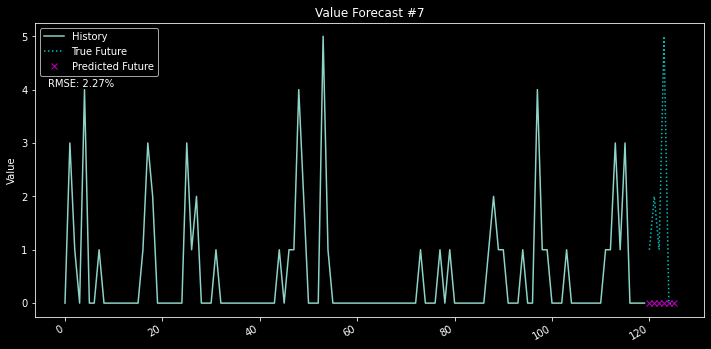

8/8 [==============================] - 0s 24ms/step


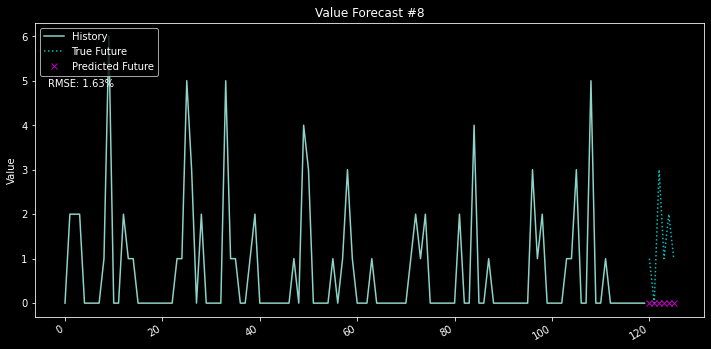

8/8 [==============================] - 0s 21ms/step


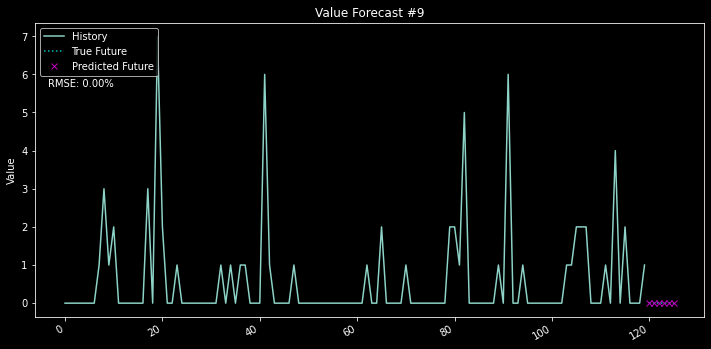

8/8 [==============================] - 0s 23ms/step


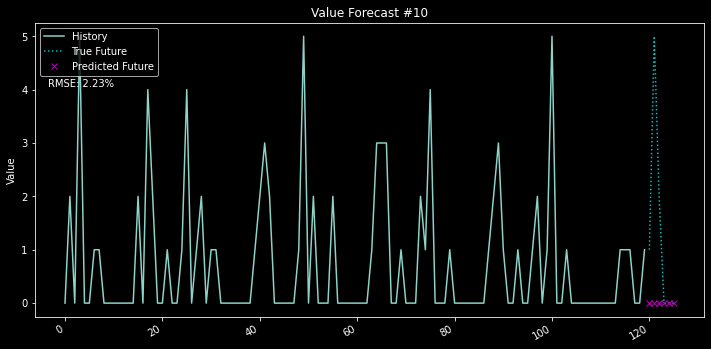

8/8 [==============================] - 0s 21ms/step


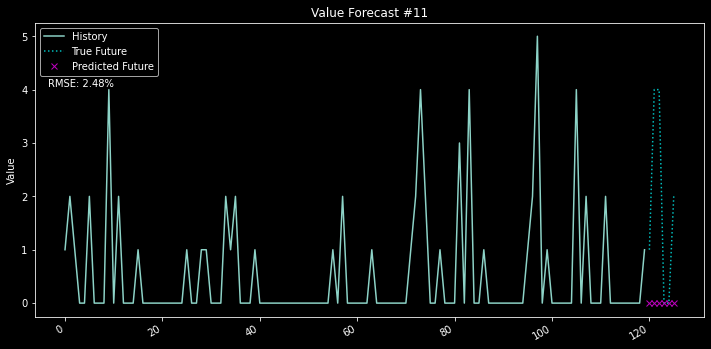

8/8 [==============================] - 0s 21ms/step


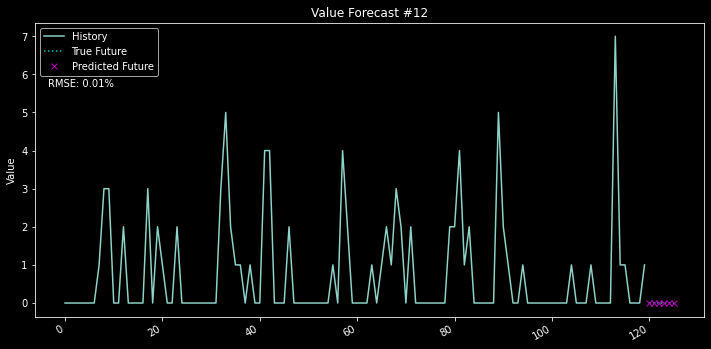

8/8 [==============================] - 0s 22ms/step


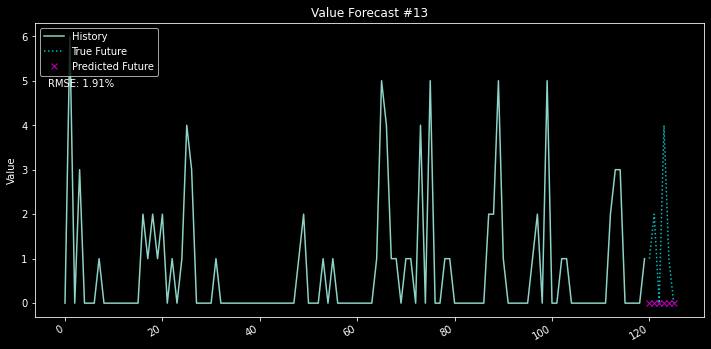

8/8 [==============================] - 0s 22ms/step


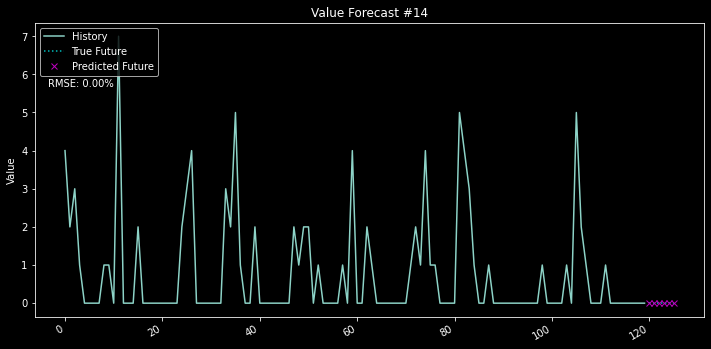

8/8 [==============================] - 0s 23ms/step


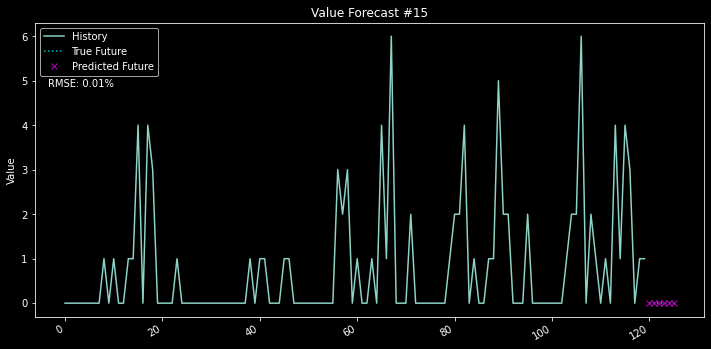

2/2 [==============================] - 0s 27ms/step


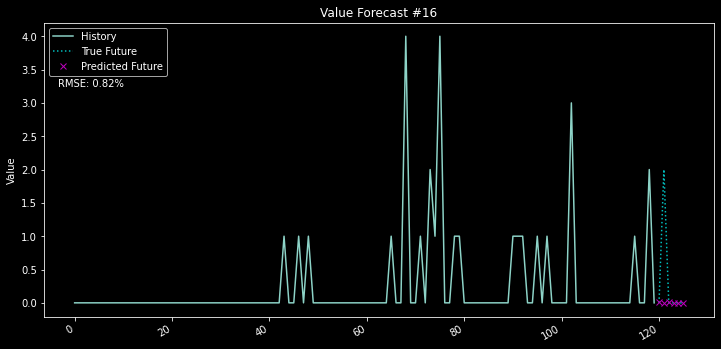

8/8 [==============================] - 0s 23ms/step


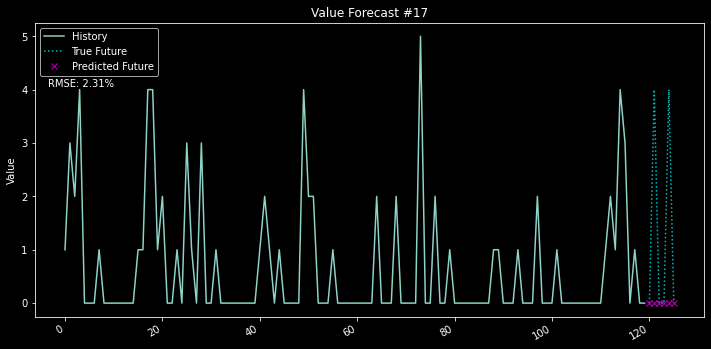

8/8 [==============================] - 0s 21ms/step


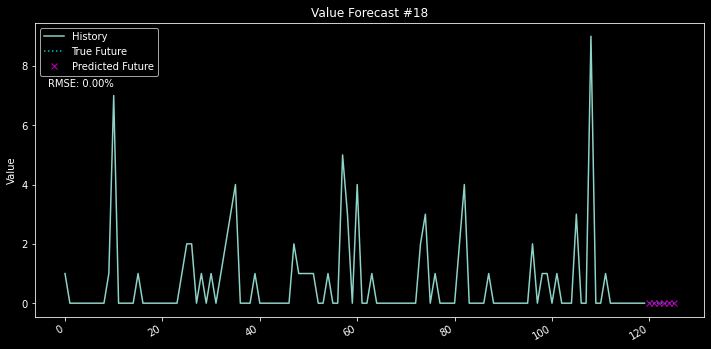

8/8 [==============================] - 0s 22ms/step


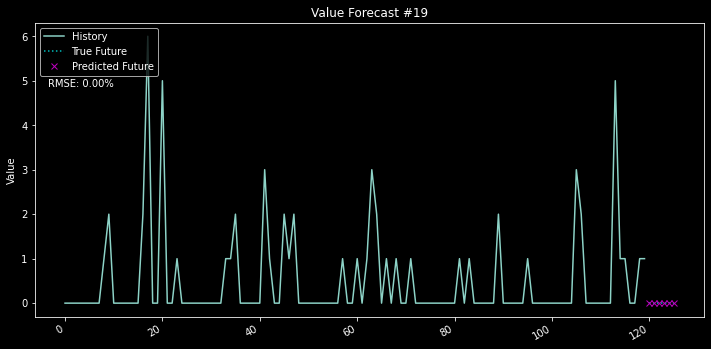

8/8 [==============================] - 0s 22ms/step


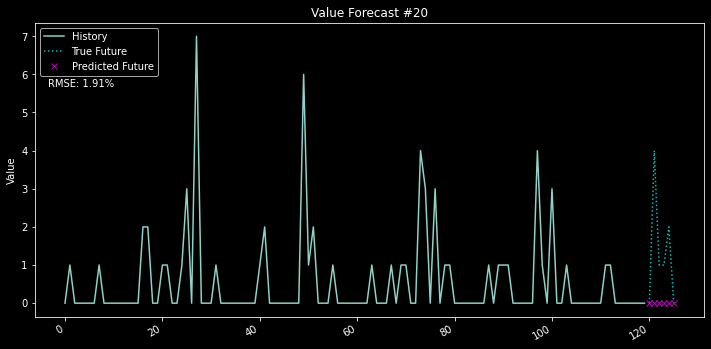

8/8 [==============================] - 0s 21ms/step


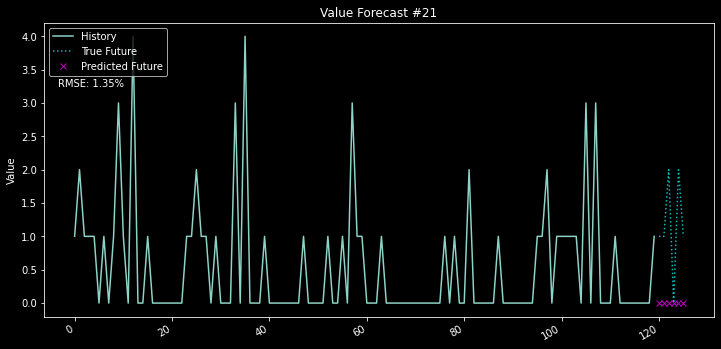

8/8 [==============================] - 0s 22ms/step


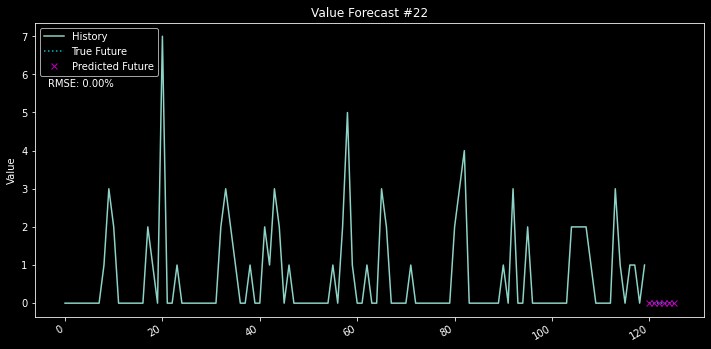

8/8 [==============================] - 0s 21ms/step


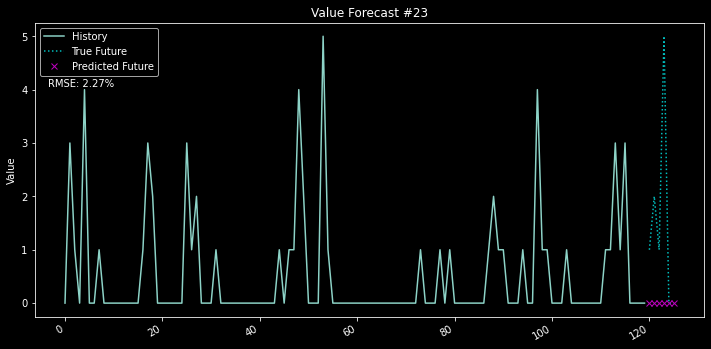

8/8 [==============================] - 0s 22ms/step


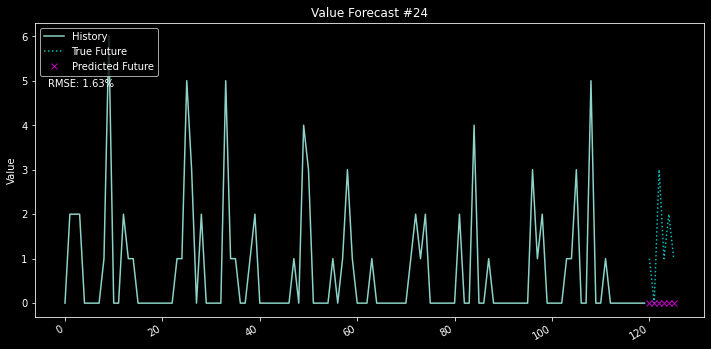

8/8 [==============================] - 0s 22ms/step


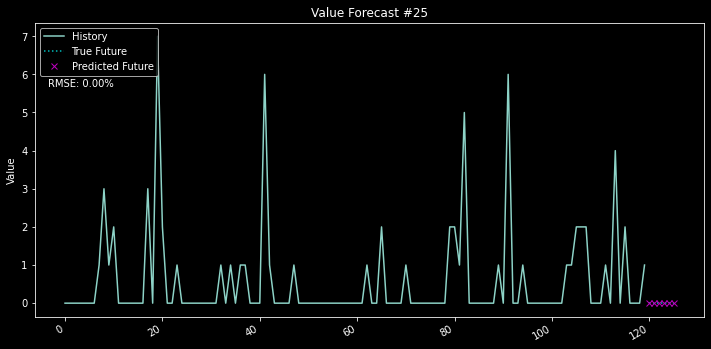

8/8 [==============================] - 0s 40ms/step


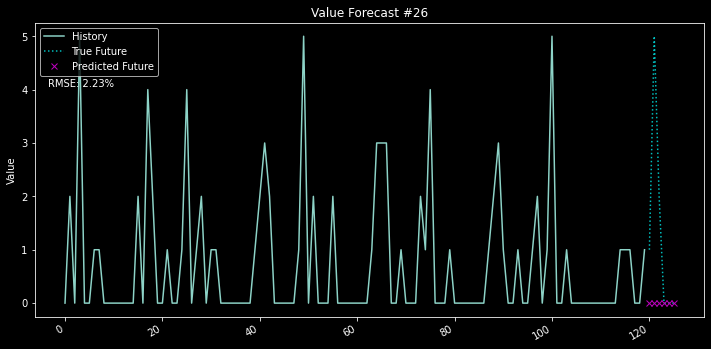

8/8 [==============================] - 0s 32ms/step


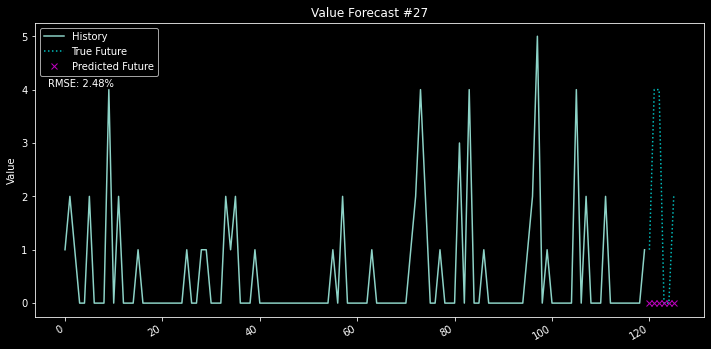

8/8 [==============================] - 0s 22ms/step


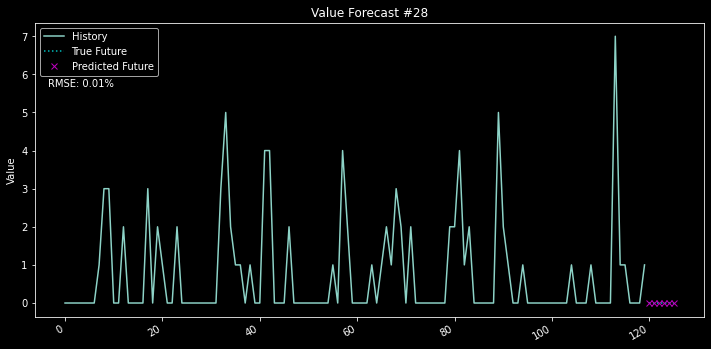

8/8 [==============================] - 0s 36ms/step


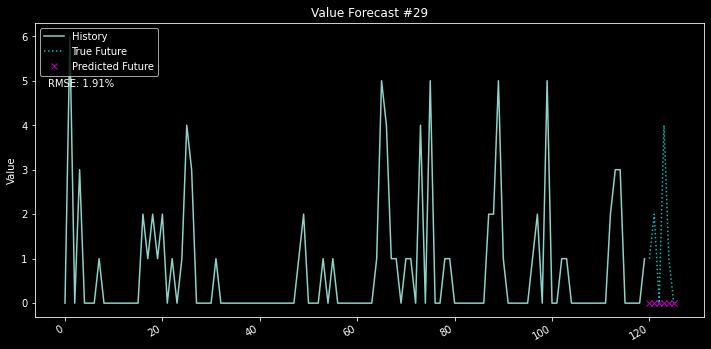

8/8 [==============================] - 0s 39ms/step


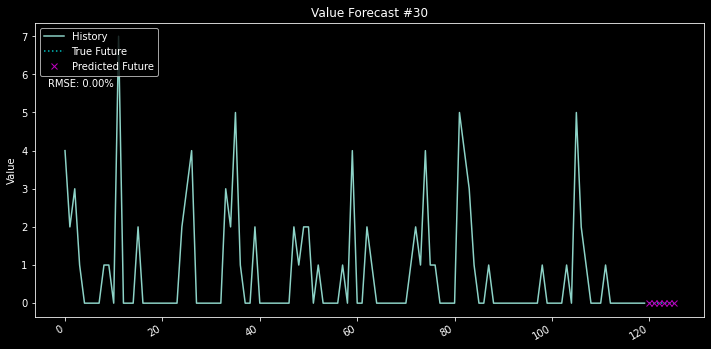

8/8 [==============================] - 0s 22ms/step


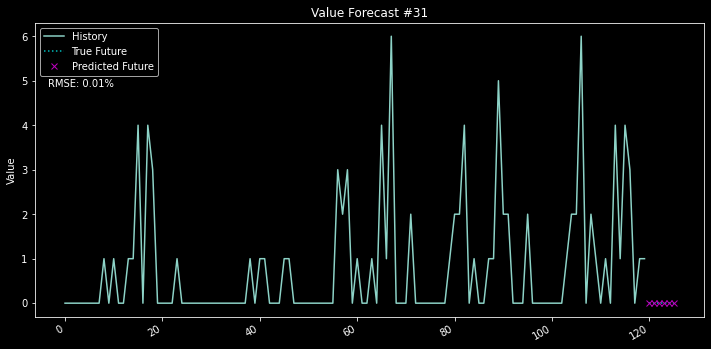

2/2 [==============================] - 0s 40ms/step


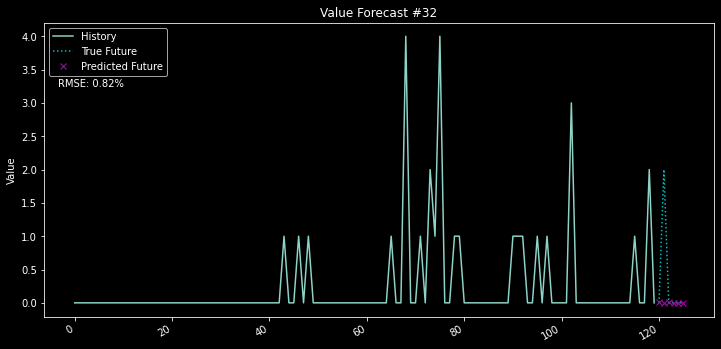

8/8 [==============================] - 0s 42ms/step


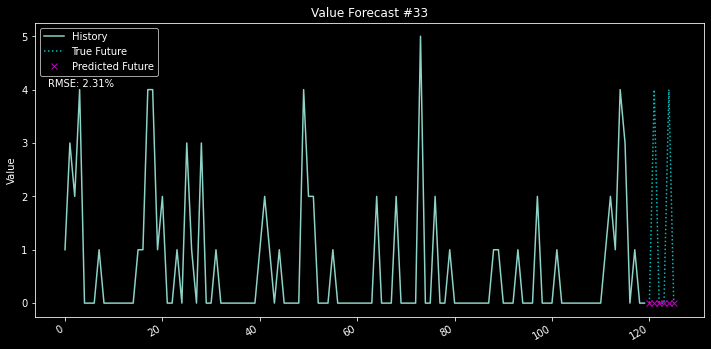

8/8 [==============================] - 0s 32ms/step


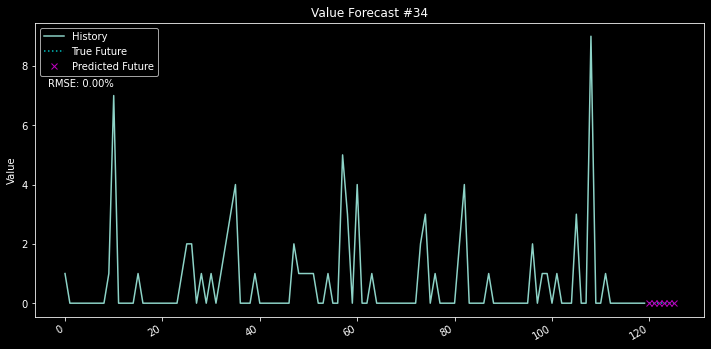

8/8 [==============================] - 0s 33ms/step


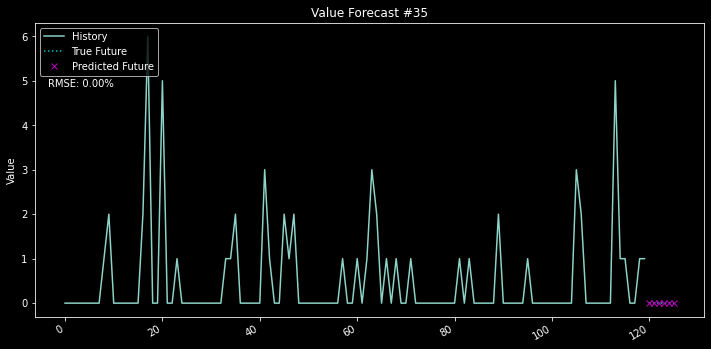

8/8 [==============================] - 0s 23ms/step


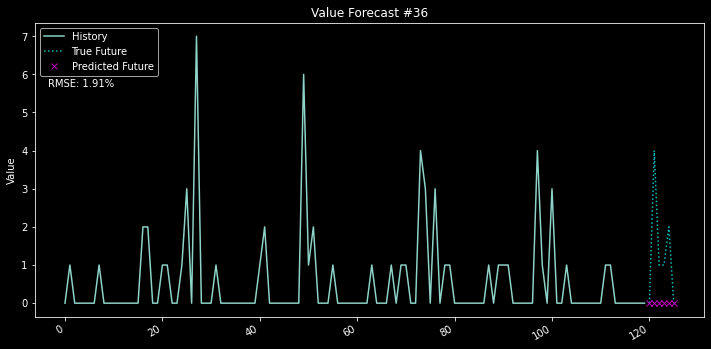

8/8 [==============================] - 0s 24ms/step


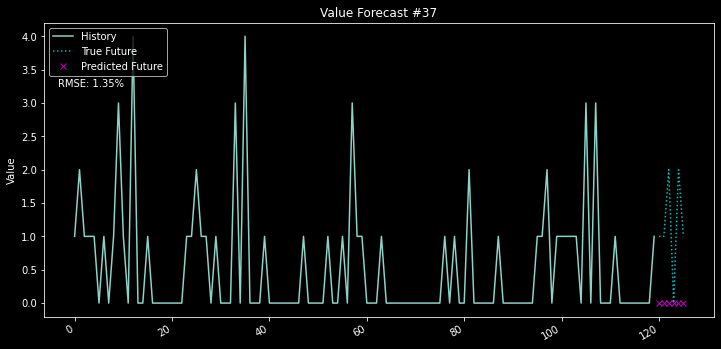

8/8 [==============================] - 0s 23ms/step


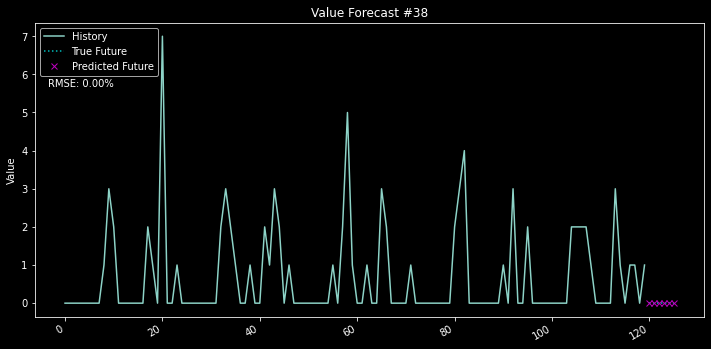

8/8 [==============================] - 0s 23ms/step


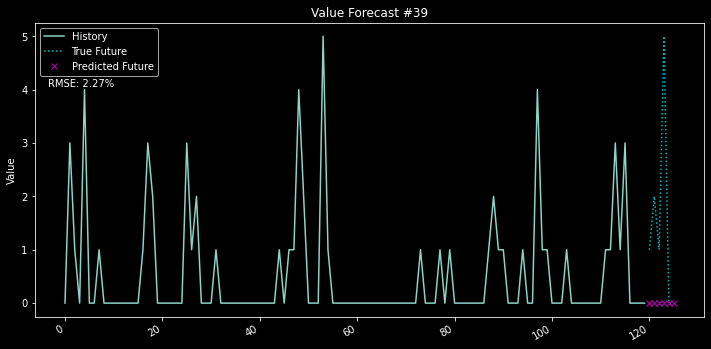

8/8 [==============================] - 0s 22ms/step


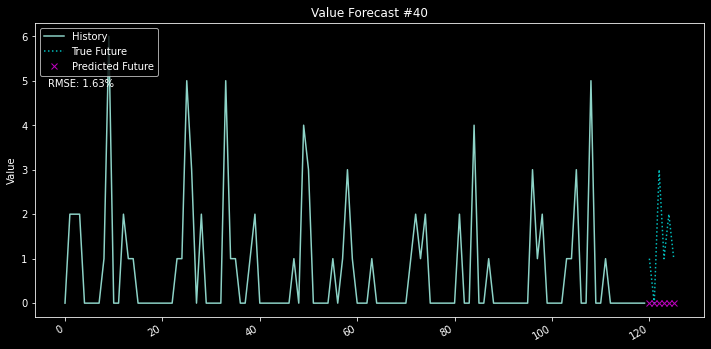

8/8 [==============================] - 0s 23ms/step


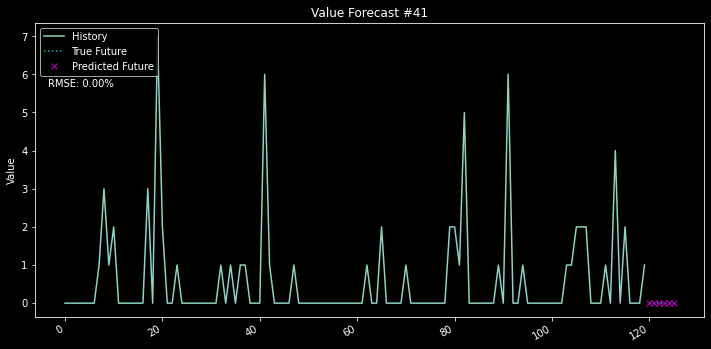

8/8 [==============================] - 0s 24ms/step


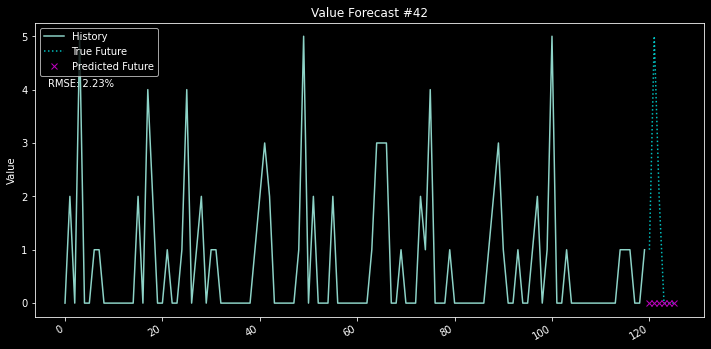

8/8 [==============================] - 0s 25ms/step


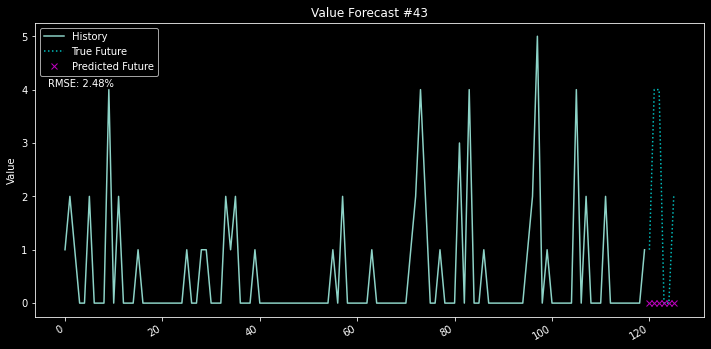

8/8 [==============================] - 0s 24ms/step


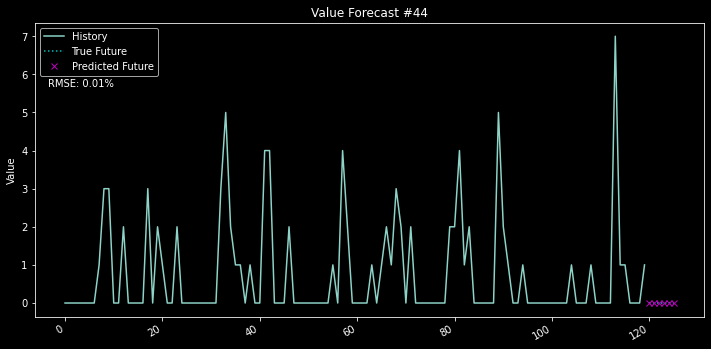

8/8 [==============================] - 0s 25ms/step


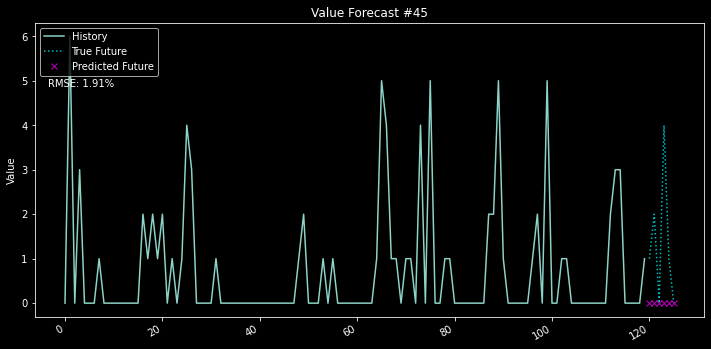

8/8 [==============================] - 0s 25ms/step


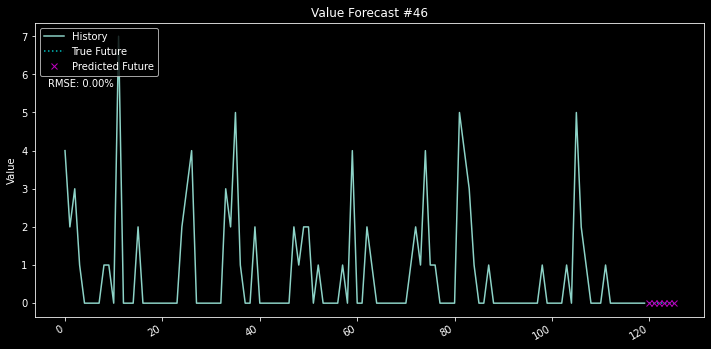

8/8 [==============================] - 0s 25ms/step


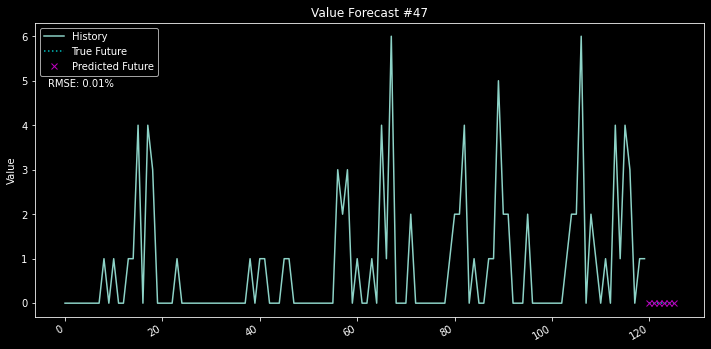

2/2 [==============================] - 0s 27ms/step


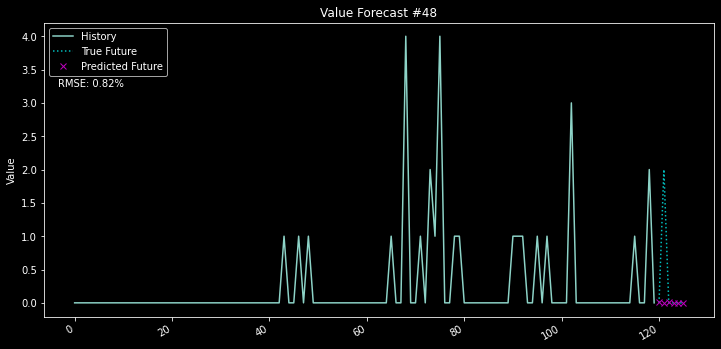

8/8 [==============================] - 0s 24ms/step


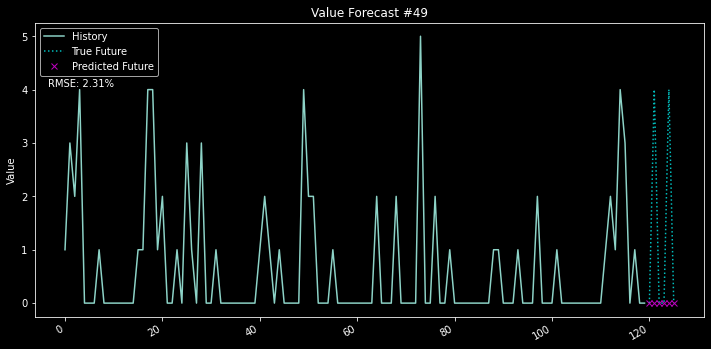

8/8 [==============================] - 0s 22ms/step


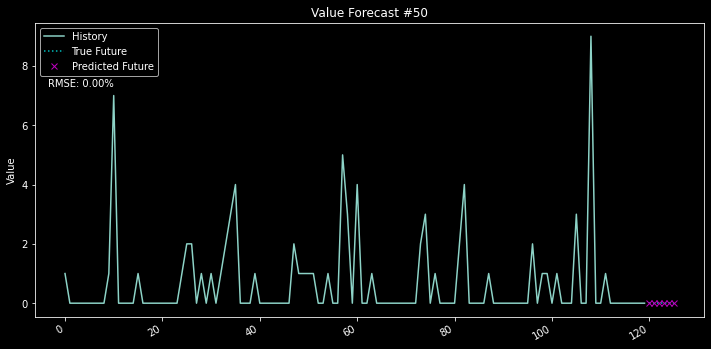

In [ ]:
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import FormatStrFormatter
from math import sqrt

# Keep track of iterations and specify the number of predictions to be made.
iter_num = -1
NUMBER_OF_PREDICTIONS = 50;

for x, y in test_data.take(NUMBER_OF_PREDICTIONS): 
  
  iter_num = iter_num + 1
  
  # Unscale history.
  history = scaler.inverse_transform(x[0].numpy())
  
  # Unscale true future.
  ground_truth = np.transpose(np.insert(np.zeros([features.shape[1]-1,future]),1,y[0],0))
  ground_truth = scaler.inverse_transform(ground_truth)[:,1]
  
  # Unscale forecasted values.
  prediction = np.transpose(np.insert(np.zeros([features.shape[1]-1,future]),1,model.predict(x)[0],0))
  prediction = scaler.inverse_transform(prediction)[:,1]
  
  # Calculate RMSE.
  rmse = sqrt(mean_squared_error(ground_truth,prediction))
    
  # Plot the graph.
  fig, ax = plt.subplots(figsize=(12,6))
  timeframe = np.arange(len(history[:,1]),len(history[:,1])+len(ground_truth))
  plt.plot(range(len(history[:,1])),
           np.array(history[:,1]),
           label='History')
  plt.plot(timeframe, 
           np.array(ground_truth), 'c:', 
           label='True Future')
  plt.plot(timeframe, 
           np.array(prediction), 'mx',
           label='Predicted Future')
  fig.autofmt_xdate() # Rotate the x-labels so that they don't overlap.
  plt.legend(loc='upper left')
  plt.ylabel("Value")
  plt.title("Value Forecast #"+str(iter_num+1))
  ax.grid(False) # Remove the grid.
  plt.text(0.02,0.81,"RMSE: %.2f%%" % rmse,
           ha='left', va='top',
           transform=ax.transAxes)
  
  plt.show()

The forecasts look pretty close to reality in general, meaning that we have reached our goal at this point. Finally, it is time to save our model, so that we can apply it to new data if we want to. 


look prediction in next 6hours

In [ ]:
prediction

array([ 0.00696206, -0.00045644,  0.0083656 ,  0.00107853, -0.00326649,
        0.00377787])

In [ ]:
# Save the model to a desired path.
model.save("model.h5")

In [ ]:
import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']

## Conclusion <a name="conclusion"></a>

In this notebook, we have used weather data to train a model which is able to predict the value, 6 hours into the future. A similar approach can be used for other time series data which resemble the one in our case, for example stock prices. 

